In [4]:
import kaggle
import pandas
import os
import re
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings

from torchvision.models import efficientnet_b0
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

from model.model import efficient_net_b0
from misc.train import train_model, test_model
from misc.plotting import get_examples
from misc.data_preprocessing import CustomImageDataset, get_statistics, download_data, create_dataloaders, get_dataloader_example


In [5]:
path = './data/'
download_data(path)

/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/misc/data_preprocessing.py:89: UserWarning: Directory already exists. Download skipped, but the code continues!
  warnings.warn(


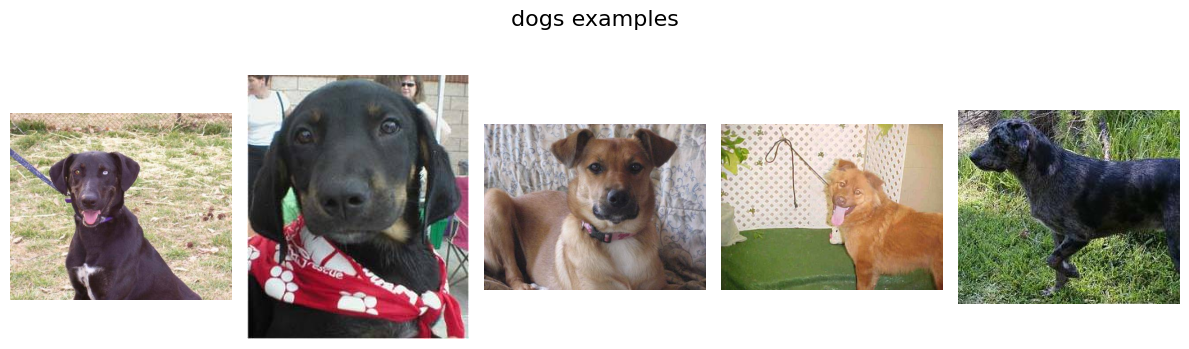

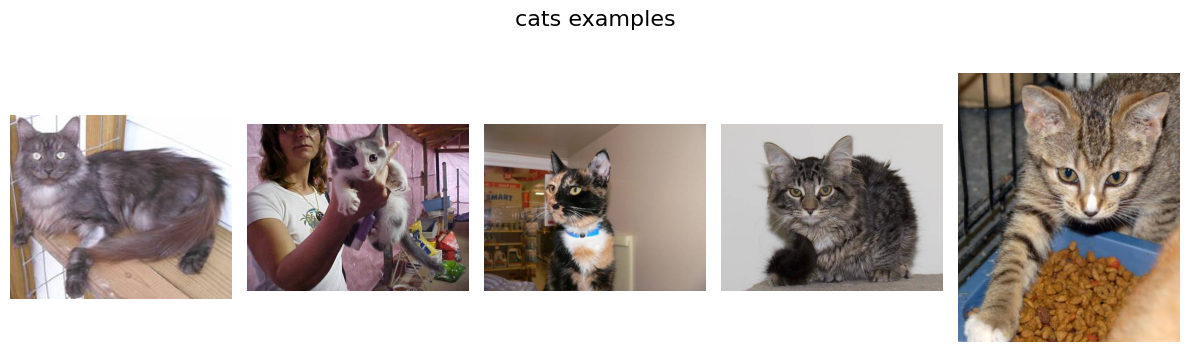

In [6]:
get_examples(5)

In [7]:
# Train Statistics
get_statistics('./data/training_set/training_set/')

# Test Statistics
get_statistics('./data/test_set/test_set/')

Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Directory not found for .DS_Store: ./data/training_set/training_set/.DS_Store/
Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Directory not found for .DS_Store: ./data/training_set/training_set/.DS_Store/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Images Shape: torch.Size([2, 3, 224, 224])
Labels Shape: torch.Size([2, 2])
Example Image:


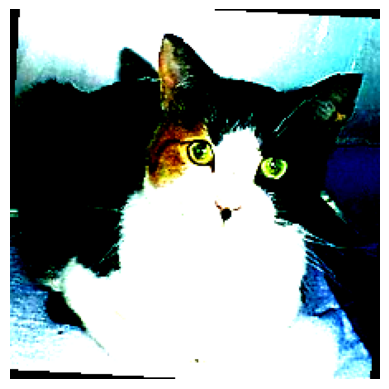

Image Class: tensor([0., 1.])


In [8]:
train_loader, val_loader, test_loader = create_dataloaders(
	train_directory_path="./data/training_set/training_set/", 
	test_directory_path="./data/test_set/test_set/", 
	batch_size=2,
	split=0.8
)

get_dataloader_example(train_loader)

In [9]:
# Our efficient net model
model = efficient_net_b0()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in our EfficientNet-B0: {total_params}')
 
# Built in pytorch efficient net model
model = efficientnet_b0(num_classes=2, pretrained=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in official EfficientNet-B0: {total_params}')

Total number of parameters in our EfficientNet-B0: 4339424
Total number of parameters in official EfficientNet-B0: 4010110


/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficient_net_b0()
model = model.to(device)

model_path = './model/model_weights.pth'
'''
if os.path.isfile(model_path):
	model.load_state_dict(torch.load(model_path)) 
	print('Model weights loaded from :', model_path)
else:
	print('No model weights were loaded')
'''

optimizer = torch.optim.Adam(
	params=model.parameters(),
	lr=1e-4
)

scheduler = ReduceLROnPlateau(
	optimizer,
	'min',
	factor=0.1,
	min_lr=1e-6
)

In [8]:
train_model(
	model,
	optimizer,
	scheduler=scheduler,
	train_loader=train_loader,
	val_loader=val_loader,
	model_path=model_path,
	epochs=200,
	patience=25,
	threshold=1e-4
)

  0%|                                          | 9/3202 [00:09<55:45,  1.05s/it]


KeyboardInterrupt: 

In [12]:
model.load_state_dict(torch.load(model_path, map_location=device))

test_model(model, test_loader)

/var/folders/c6/bflj7jtn117gmc20cqnz2sg40000gn/T/ipykernel_87630/351965825.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

KeyboardInterrupt: 

In [ ]:


import zipfile

# Path to your zip file
zip_file_path = 'dogs_vs_cats_2.zip'

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dogs_vs_cats_2')  # Specify the extraction path